In [1]:
##### MODELING LIBRARIES #####
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.random import set_seed
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from patsy import dmatrices, dmatrix

##### FORMATTING AND GRAPHING LIBRARIES #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

##### TIMING AND UTILITY LIBRARIES #####
from datetime import datetime
import timeit
from dateutil.relativedelta import relativedelta 
import random

In [2]:
# MAPE function taken from:
# https://www.statology.org/mape-python/
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [3]:
##### IMPORT PREPARED DATA #####
print('Reading pre-built dataset...')
df_full = pd.read_csv('../PJM_Weekly_Model/sample_base_data.csv', index_col = 0, parse_dates = [0])

# Drop all lag columns for use in RNN
lag_sq_cols = [column for column in df_full.columns if 'Lag' in column or 'Sq' in column]
df_full = df_full.drop(columns = lag_sq_cols)

# Infill remaining nulls (from missing daylight savings hour) with previous value
backfilled = df_full.isna().sum().sum()
print('Backfilling %s null values...'%(backfilled))
df_full = df_full.fillna(method = 'backfill')

# Convert date, time, holiday columns to categorical variables
for col in ['Month','WeekDay','Day','Hour']:
    df_full[col] = df_full[col].astype('category')
    
# Create dataframe for actual loads and predicted train and test values
df_train = pd.DataFrame(df_full['value'])
df_test = pd.DataFrame(df_full['value'])

Reading pre-built dataset...
Backfilling 1 null values...


In [4]:
# Define final parameters
param_dict = {'seq_length':12,
              'seq_batch_size':256,
              'layer_one_neurons':128,
              'layer_two_neurons':32,
              'layer_three_neurons':16,
              'layer_four_neurons':16,
              'dropout_rate':0,
              'stop_patience':4,
              'learning_rate':0.01,
              'epochs':40
             }

In [5]:
##### RNN ON MOVING TRAINING WINDOW #####
tic = timeit.default_timer()
print("\nDefining training set, building and training models...")

# Define shift variable for taking moving sample of data
data_shift = 0

while data_shift + 18240 < df_full.shape[0]:
# while data_shift == 0 :
    ##### FINAL DATA PREPARATION #####
    
    # Limit dataset to roughly 13 months of data (18240 hours)
    df_modeling = df_full.iloc[data_shift:18240 + data_shift,:].copy()
    
    # Use Patsy to create the one-hot encoded dummy variables with interactions 
    y, X =  dmatrices('value~Light+WWP+THI+Month+Day+WeekDay+Hour+Holiday',df_modeling,return_type='dataframe')

    # Split data into training and testing data sets with two-year training sample (8760 h/yr * 2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 17520 / X.shape[0], shuffle = False)

    # Standardize both datasets - create fit to use on backcast dataset
    ss = StandardScaler()

    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)
    
    # Limit dataset to roughly 13 months of data (18240 hours)
    df_modeling = df_full.iloc[data_shift:18240 + data_shift,:].copy()

    # Set random seed
    random.seed(283)
    set_seed(283)

    # Create output dataframes for individual predictions
    df_preds_train = pd.DataFrame()
    df_preds_test = pd.DataFrame()

    for x in range(5):
        # Create training sequences
        train_sequences = TimeseriesGenerator(X_train_ss, y_train['value'],
                                              length = param_dict['seq_length'],
                                              batch_size = param_dict['seq_batch_size'])

        # Create test sequences
        test_sequences = TimeseriesGenerator(X_test_ss, y_test['value']
                                             ,length = param_dict['seq_length']
                                             ,batch_size = param_dict['seq_batch_size'])

        ##### RNN MODEL #####
        # Instantiate model and construct all layers
        model = Sequential()
        model.add(GRU(param_dict['layer_one_neurons'], input_shape = (param_dict['seq_length'],75),
                      return_sequences = True, activation = 'relu', ))
        model.add(Dropout(param_dict['dropout_rate']))
        model.add(GRU(param_dict['layer_two_neurons'], return_sequences = True, activation = 'relu'))
        model.add(Dropout(param_dict['dropout_rate']))
        model.add(GRU(param_dict['layer_three_neurons'], return_sequences = True, activation = 'relu'))
        model.add(Dropout(param_dict['dropout_rate']))
        model.add(GRU(param_dict['layer_four_neurons'], return_sequences = False, activation = 'relu'))
        model.add(Dropout(param_dict['dropout_rate']))
        model.add(Dense(1, activation = 'linear'))

        # Compile and fit model
        model.compile(optimizer = Adam(learning_rate = param_dict['learning_rate']),
                      loss = 'mean_squared_error',
                      metrics = 'mean_absolute_percentage_error')

        early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience = param_dict['stop_patience'], verbose=1, mode='auto')

        model.fit(train_sequences,
                  validation_data = test_sequences,
                  epochs = param_dict['epochs'],
                  callbacks = [early_stop],
                  verbose = False)

        # Write predictions to dataframe, adding nulls equal to lag
        df_preds_train[x] = np.append([np.NaN] * param_dict['seq_length'], model.predict(train_sequences).transpose())
        df_preds_test[x] = np.append([np.NaN] * param_dict['seq_length'], model.predict(test_sequences).transpose())

    # Define name for current model as first date of the testing dataset
    model_date = datetime.date(X_test.index[0])
    
    # Create ensemble prediction and add to final output dataframes
    # NOTE: This would be a good spot for future improvement by creating weighting for the ensemble models
    y_train[model_date] = df_preds_train.mean(axis=1).tolist()
    y_test[model_date] = df_preds_test.mean(axis=1).tolist()
    
    # Output model results
    print('\n%s Model Results' % (model_date))
    
    # Create mask to exclude all records with null values for the give dataset
    mask_train = (y_train[model_date].notna())
    mask_test = (y_test[model_date].notna())
    
    # Calculate r2 scores for training and testing data
    train_r2 = round(r2_score(y_train.loc[mask_train, model_date],y_train.loc[mask_train, 'value']),3)
    test_r2 = round(r2_score(y_test.loc[mask_test, model_date],y_test.loc[mask_test, 'value']),3)
    print('Training data r2: %s' % (train_r2))
    print('Testing data r2: %s' % (test_r2))

    # Calculate MAPE scores for training and testing data
    train_mape = round(mape(y_train.loc[mask_train, model_date],y_train.loc[mask_train, 'value']),3)
    test_mape = round(mape(y_test.loc[mask_test, model_date],y_test.loc[mask_test, 'value']),3)
    print('Training data MAPE: %s' % (train_mape))
    print('Testing data MAPE: %s' % (test_mape))

    # Add the model predictions to the respective dataframes
    df_train = pd.merge(df_train, y_train.drop(columns = 'value'), how = 'left', left_index = True, right_index = True)
    df_test = pd.merge(df_test, y_test.drop(columns = 'value'), how = 'left', left_index = True, right_index = True)
    
    # Increment the data shift by one week (168 hours)
    data_shift += 168

toc = timeit.default_timer()
print('\nAll RNN fits completed in %0.2f seconds' % (toc-tic))


Defining training set, building and training models...
Epoch 00015: early stopping
Epoch 00014: early stopping
Epoch 00008: early stopping
Epoch 00015: early stopping
Epoch 00019: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2018-12-31 Model Results
Training data r2: 0.773
Testing data r2: 0.414
Training data MAPE: 6.0
Testing data MAPE: 5.175
Epoch 00007: early stopping
Epoch 00009: early stopping
Epoch 00013: early stopping
Epoch 00013: early stopping
Epoch 00017: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-01-07 Model Results
Training data r2: 0.751
Testing data r2: -0.693
Training data MAPE: 6.068
Testing data MAPE: 11.017
Epoch 00017: early stopping
Epoch 00010: early stopping
Epoch 00012: early stopping
Epoch 00014: early stopping
Epoch 00017: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-01-14 Model Results
Training data r2: 0.437
Testing data r2: -0.392
Training data MAPE: 10.481
Testing data MAPE: 13.288
Epoch 00025: early stopping
Epoch 00015: early stopping
Epoch 00010: early stopping
Epoch 00023: early stopping
Epoch 00008: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-01-21 Model Results
Training data r2: -4.44
Testing data r2: -11.857
Training data MAPE: 33.207
Testing data MAPE: 46.976
Epoch 00008: early stopping
Epoch 00009: early stopping
Epoch 00011: early stopping
Epoch 00008: early stopping
Epoch 00012: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-01-28 Model Results
Training data r2: 0.796
Testing data r2: 0.661
Training data MAPE: 4.868
Testing data MAPE: 5.148
Epoch 00008: early stopping
Epoch 00009: early stopping
Epoch 00007: early stopping
Epoch 00013: early stopping
Epoch 00020: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-02-04 Model Results
Training data r2: 0.789
Testing data r2: 0.601
Training data MAPE: 5.941
Testing data MAPE: 5.189
Epoch 00010: early stopping
Epoch 00008: early stopping
Epoch 00007: early stopping
Epoch 00009: early stopping
Epoch 00012: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-02-11 Model Results
Training data r2: 0.566
Testing data r2: 0.055
Training data MAPE: 6.444
Testing data MAPE: 6.876
Epoch 00009: early stopping
Epoch 00018: early stopping
Epoch 00007: early stopping
Epoch 00024: early stopping
Epoch 00009: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-02-18 Model Results
Training data r2: -1.926
Testing data r2: -11.86
Training data MAPE: 29.503
Testing data MAPE: 37.354
Epoch 00021: early stopping
Epoch 00011: early stopping
Epoch 00024: early stopping
Epoch 00010: early stopping
Epoch 00016: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-02-25 Model Results
Training data r2: 0.865
Testing data r2: 0.723
Training data MAPE: 4.37
Testing data MAPE: 4.129
Epoch 00016: early stopping
Epoch 00014: early stopping
Epoch 00007: early stopping
Epoch 00014: early stopping
Epoch 00009: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-03-04 Model Results
Training data r2: 0.828
Testing data r2: 0.344
Training data MAPE: 4.847
Testing data MAPE: 6.008
Epoch 00008: early stopping
Epoch 00006: early stopping
Epoch 00016: early stopping
Epoch 00020: early stopping
Epoch 00013: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-03-11 Model Results
Training data r2: 0.689
Testing data r2: -0.076
Training data MAPE: 7.003
Testing data MAPE: 8.823
Epoch 00015: early stopping
Epoch 00015: early stopping
Epoch 00014: early stopping
Epoch 00010: early stopping
Epoch 00009: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-03-18 Model Results
Training data r2: 0.512
Testing data r2: 0.649
Training data MAPE: 7.5
Testing data MAPE: 5.412
Epoch 00008: early stopping
Epoch 00009: early stopping
Epoch 00013: early stopping
Epoch 00015: early stopping
Epoch 00021: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-03-25 Model Results
Training data r2: 0.788
Testing data r2: 0.394
Training data MAPE: 5.95
Testing data MAPE: 6.757
Epoch 00017: early stopping
Epoch 00010: early stopping
Epoch 00015: early stopping
Epoch 00019: early stopping
Epoch 00012: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-04-01 Model Results
Training data r2: 0.849
Testing data r2: 0.854
Training data MAPE: 4.469
Testing data MAPE: 3.197
Epoch 00006: early stopping
Epoch 00015: early stopping
Epoch 00011: early stopping
Epoch 00018: early stopping
Epoch 00010: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-04-08 Model Results
Training data r2: -2.363
Testing data r2: -2.919
Training data MAPE: 27.378
Testing data MAPE: 23.096
Epoch 00017: early stopping
Epoch 00010: early stopping
Epoch 00013: early stopping
Epoch 00007: early stopping
Epoch 00017: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-04-15 Model Results
Training data r2: 0.834
Testing data r2: 0.757
Training data MAPE: 4.415
Testing data MAPE: 4.227
Epoch 00008: early stopping
Epoch 00010: early stopping
Epoch 00011: early stopping
Epoch 00014: early stopping
Epoch 00007: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-04-22 Model Results
Training data r2: 0.614
Testing data r2: 0.811
Training data MAPE: 7.436
Testing data MAPE: 4.175
Epoch 00013: early stopping
Epoch 00006: early stopping
Epoch 00023: early stopping
Epoch 00015: early stopping
Epoch 00011: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-04-29 Model Results
Training data r2: 0.8
Testing data r2: 0.641
Training data MAPE: 5.392
Testing data MAPE: 6.393
Epoch 00016: early stopping
Epoch 00016: early stopping
Epoch 00015: early stopping
Epoch 00016: early stopping
Epoch 00009: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-05-06 Model Results
Training data r2: 0.855
Testing data r2: 0.697
Training data MAPE: 4.326
Testing data MAPE: 5.707
Epoch 00013: early stopping
Epoch 00014: early stopping
Epoch 00024: early stopping
Epoch 00009: early stopping
Epoch 00014: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-05-13 Model Results
Training data r2: 0.735
Testing data r2: 0.697
Training data MAPE: 5.78
Testing data MAPE: 6.368
Epoch 00016: early stopping
Epoch 00011: early stopping
Epoch 00008: early stopping
Epoch 00011: early stopping
Epoch 00013: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-05-20 Model Results
Training data r2: 0.753
Testing data r2: 0.569
Training data MAPE: 5.426
Testing data MAPE: 8.079
Epoch 00009: early stopping
Epoch 00010: early stopping
Epoch 00011: early stopping
Epoch 00011: early stopping
Epoch 00014: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-05-27 Model Results
Training data r2: 0.283
Testing data r2: 0.462
Training data MAPE: 10.136
Testing data MAPE: 8.649
Epoch 00006: early stopping
Epoch 00017: early stopping
Epoch 00016: early stopping
Epoch 00008: early stopping
Epoch 00014: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-06-03 Model Results
Training data r2: 0.07
Testing data r2: 0.077
Training data MAPE: 12.558
Testing data MAPE: 11.136
Epoch 00007: early stopping
Epoch 00008: early stopping
Epoch 00011: early stopping
Epoch 00010: early stopping
Epoch 00008: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-06-10 Model Results
Training data r2: 0.381
Testing data r2: 0.481
Training data MAPE: 9.844
Testing data MAPE: 9.169
Epoch 00026: early stopping
Epoch 00008: early stopping
Epoch 00016: early stopping
Epoch 00016: early stopping
Epoch 00013: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-06-17 Model Results
Training data r2: 0.852
Testing data r2: 0.706
Training data MAPE: 4.594
Testing data MAPE: 6.932
Epoch 00011: early stopping
Epoch 00012: early stopping
Epoch 00006: early stopping
Epoch 00008: early stopping
Epoch 00009: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-06-24 Model Results
Training data r2: 0.662
Testing data r2: 0.051
Training data MAPE: 6.243
Testing data MAPE: 13.489
Epoch 00013: early stopping
Epoch 00015: early stopping
Epoch 00008: early stopping
Epoch 00011: early stopping
Epoch 00009: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-07-01 Model Results
Training data r2: 0.787
Testing data r2: 0.542
Training data MAPE: 5.178
Testing data MAPE: 8.747
Epoch 00011: early stopping
Epoch 00013: early stopping
Epoch 00010: early stopping
Epoch 00011: early stopping
Epoch 00013: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-07-08 Model Results
Training data r2: -0.526
Testing data r2: -1.859
Training data MAPE: 16.35
Testing data MAPE: 24.283
Epoch 00012: early stopping
Epoch 00018: early stopping
Epoch 00014: early stopping
Epoch 00016: early stopping
Epoch 00016: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-07-15 Model Results
Training data r2: 0.814
Testing data r2: 0.829
Training data MAPE: 5.999
Testing data MAPE: 5.871
Epoch 00014: early stopping
Epoch 00013: early stopping
Epoch 00013: early stopping
Epoch 00017: early stopping
Epoch 00011: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-07-22 Model Results
Training data r2: 0.173
Testing data r2: -0.045
Training data MAPE: 11.07
Testing data MAPE: 13.474
Epoch 00015: early stopping
Epoch 00012: early stopping
Epoch 00012: early stopping
Epoch 00014: early stopping
Epoch 00008: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-07-29 Model Results
Training data r2: 0.742
Testing data r2: 0.557
Training data MAPE: 5.84
Testing data MAPE: 8.766
Epoch 00011: early stopping
Epoch 00009: early stopping
Epoch 00016: early stopping
Epoch 00012: early stopping
Epoch 00013: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-08-05 Model Results
Training data r2: 0.815
Testing data r2: 0.639
Training data MAPE: 5.598
Testing data MAPE: 8.953
Epoch 00012: early stopping
Epoch 00012: early stopping
Epoch 00018: early stopping
Epoch 00015: early stopping
Epoch 00009: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-08-12 Model Results
Training data r2: 0.867
Testing data r2: 0.79
Training data MAPE: 4.485
Testing data MAPE: 6.548
Epoch 00007: early stopping
Epoch 00014: early stopping
Epoch 00007: early stopping
Epoch 00008: early stopping
Epoch 00012: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-08-19 Model Results
Training data r2: 0.486
Testing data r2: 0.422
Training data MAPE: 9.313
Testing data MAPE: 11.342
Epoch 00018: early stopping
Epoch 00011: early stopping
Epoch 00012: early stopping
Epoch 00011: early stopping
Epoch 00008: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-08-26 Model Results
Training data r2: 0.803
Testing data r2: 0.692
Training data MAPE: 5.094
Testing data MAPE: 6.639
Epoch 00014: early stopping
Epoch 00010: early stopping
Epoch 00010: early stopping
Epoch 00009: early stopping
Epoch 00024: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-09-02 Model Results
Training data r2: 0.885
Testing data r2: 0.615
Training data MAPE: 4.208
Testing data MAPE: 7.075
Epoch 00011: early stopping
Epoch 00020: early stopping
Epoch 00014: early stopping
Epoch 00014: early stopping
Epoch 00009: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-09-09 Model Results
Training data r2: 0.847
Testing data r2: 0.692
Training data MAPE: 4.799
Testing data MAPE: 6.303
Epoch 00015: early stopping
Epoch 00008: early stopping
Epoch 00021: early stopping
Epoch 00006: early stopping
Epoch 00008: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-09-16 Model Results
Training data r2: 0.845
Testing data r2: 0.583
Training data MAPE: 4.745
Testing data MAPE: 8.384
Epoch 00006: early stopping
Epoch 00011: early stopping
Epoch 00016: early stopping
Epoch 00012: early stopping
Epoch 00021: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-09-23 Model Results
Training data r2: 0.677
Testing data r2: 0.501
Training data MAPE: 7.54
Testing data MAPE: 5.697
Epoch 00019: early stopping
Epoch 00008: early stopping
Epoch 00007: early stopping
Epoch 00011: early stopping
Epoch 00012: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-09-30 Model Results
Training data r2: 0.612
Testing data r2: 0.2
Training data MAPE: 9.109
Testing data MAPE: 5.832
Epoch 00014: early stopping
Epoch 00015: early stopping
Epoch 00011: early stopping
Epoch 00017: early stopping
Epoch 00011: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-10-07 Model Results
Training data r2: 0.835
Testing data r2: -0.015
Training data MAPE: 5.153
Testing data MAPE: 10.043
Epoch 00024: early stopping
Epoch 00013: early stopping
Epoch 00009: early stopping
Epoch 00013: early stopping
Epoch 00015: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-10-14 Model Results
Training data r2: 0.899
Testing data r2: 0.717
Training data MAPE: 3.965
Testing data MAPE: 4.352
Epoch 00013: early stopping
Epoch 00013: early stopping
Epoch 00021: early stopping
Epoch 00007: early stopping
Epoch 00015: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-10-21 Model Results
Training data r2: 0.89
Testing data r2: 0.771
Training data MAPE: 4.183
Testing data MAPE: 4.007
Epoch 00008: early stopping
Epoch 00009: early stopping
Epoch 00020: early stopping
Epoch 00009: early stopping
Epoch 00012: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-10-28 Model Results
Training data r2: 0.761
Testing data r2: 0.231
Training data MAPE: 6.214
Testing data MAPE: 6.178
Epoch 00014: early stopping
Epoch 00009: early stopping
Epoch 00009: early stopping
Epoch 00014: early stopping
Epoch 00007: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-11-04 Model Results
Training data r2: 0.844
Testing data r2: 0.626
Training data MAPE: 4.984
Testing data MAPE: 4.382
Epoch 00015: early stopping
Epoch 00016: early stopping
Epoch 00008: early stopping
Epoch 00009: early stopping
Epoch 00014: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-11-11 Model Results
Training data r2: 0.516
Testing data r2: -0.656
Training data MAPE: 8.703
Testing data MAPE: 10.435
Epoch 00011: early stopping
Epoch 00014: early stopping
Epoch 00019: early stopping
Epoch 00010: early stopping
Epoch 00011: early stopping


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-11-18 Model Results
Training data r2: 0.841
Testing data r2: 0.566
Training data MAPE: 4.964
Testing data MAPE: 5.215
Epoch 00012: early stopping
Epoch 00010: early stopping
Epoch 00007: early stopping
Epoch 00010: early stopping
Epoch 00006: early stopping

2019-11-25 Model Results
Training data r2: 0.708
Testing data r2: -0.052
Training data MAPE: 6.602
Testing data MAPE: 6.89

All RNN fits completed in 16204.68 seconds


C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
# Write prediction dataframes to CSV
df_train.to_csv('../Outputs/RNN_validation_train_preds.csv')
df_test.to_csv('../Outputs/RNN_validation_test_preds.csv')

In [7]:
# Write model scores to data frame - Meant to include this in loop initially
# Create dataframe for scores
df_scores = pd.DataFrame(index = df_train.drop(columns = 'value').columns)

# Create empty columns for scores
df_scores['train_r2'], df_scores['test_r2'], df_scores['train_mape'], df_scores['test_mape'] = [np.nan,np.nan,np.nan,np.nan]

# Loop through each forecast
for column in df_train.columns[1:]:
    # Slice training and testing dataframes to desired forecast
    df_train_calc = df_train[['value',column]].dropna()
    df_test_calc = df_test[['value',column]].dropna()
    
    # Calciulate r2 scores for training and testing data
    train_r2 = round(r2_score(df_train_calc['value'],df_train_calc[column]),3)
    test_r2 = round(r2_score(df_test_calc['value'],df_test_calc[column]),3)

    # Calculate MAPE scores for training and testing data
    train_mape = round(mape(df_train_calc['value'],df_train_calc[column]),2)
    test_mape = round(mape(df_test_calc['value'],df_test_calc[column]),2)
    
    # Assign scores
    df_scores.loc[df_scores.index == column,:] = [train_r2, test_r2, train_mape, test_mape]

In [8]:
# Write scores dataframes to CSV
df_scores.to_csv('../Outputs/RNN_validation_scores.csv')

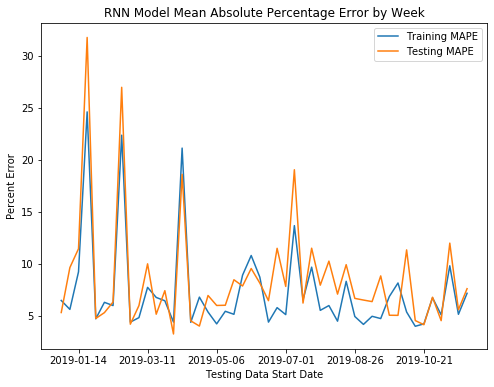

In [9]:
plt.figure(figsize = (8,6))
plt.plot(df_scores[['train_mape','test_mape']])
plt.xticks(df_scores.index[2::8])
plt.xlabel('Testing Data Start Date')
plt.ylabel('Percent Error')
plt.title('RNN Model Mean Absolute Percentage Error by Week')
plt.legend(labels = ['Training MAPE','Testing MAPE']);